<a href="https://colab.research.google.com/github/snehasharma0807/epileptic-youth-project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Imports
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#install and import packages
!pip install ipython-autotime
%load_ext autotime
# !pip install mne
import tensorflow as tf
from tensorflow import keras
# import os
# import mne
# from mne import create_info
# from mne.viz import plot_topomap
import numpy as np
import torch
import io
import matplotlib.pyplot as plt


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
time: 6.92 s (started: 2023-12-05 06:48:45 +00:00)


In [ ]:
# @title Preprocessing Data: Functions
def getTimeFreqTopoData(EEG):
  times = []
  sec_increment = 10 * 60  # 10 minutes
  trange = np.arange(EEG.times[0], EEG.times[-1] + sec_increment, sec_increment)
  for i in np.arange(len(trange) - 1):
    times.append((trange[i], trange[i + 1]))

  bands = []
  frange = np.arange(80, 260, 10)  # Adjusted frequency range
  for i in np.arange(len(frange) - 1):
    bands.append((frange[i], frange[i + 1]))

  tf_topodata = []
  for t in times:
    print(t[0], '-', t[1])
    spectrum = EEG.compute_psd(tmin=t[0], tmax=t[1])
    freq_topodata = getTopoData(spectrum, bands)
    tf_topodata.append(freq_topodata)
  tf_topodata = np.stack(tf_topodata)
  return tf_topodata



def getTopoData(spectrum, bands):
  data = []
  for band in bands:
    data.append(getTopoBandData(spectrum, band))
  data = np.stack(data)
  return data

def getTopoBandData(spectrum, band):
  fig, ax1 = plt.subplots()
  fig.set_size_inches(2,2)
  spectrum.plot_topomap(axes=ax1, bands={'':band}, dB=True, cmap='gray', contours=0, outlines='head', sensors=False);
  fig.get_axes()[1].remove() #remove colorbar
  fig.get_axes()[0].set_title(None)

  with io.BytesIO() as buff:
    fig.savefig(buff, format='raw')
    buff.seek(0)
    data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
  w, h = fig.canvas.get_width_height()
  im = data.reshape((int(h), int(w), -1))
  im = im[30:155, 25:150, 0]
  plt.close()
  return im

time: 1.47 ms (started: 2023-08-11 01:53:23 +00:00)


In [ ]:
# @title Preprocessing Data
subjects = ["24", "25", "26", "27", "28", "29", "30"]

for subj in subjects:
  #loading data
  sample_data_folder =("/content/drive/MyDrive/projectcode")
  sample_data_raw_file = os.path.join(sample_data_folder,'sub-'+ subj + '_ses-01_task-hfo_eeg.edf')
  raw = mne.io.read_raw_edf(sample_data_raw_file,preload = True)
  raw.load_data()

  #check channels
  print(raw.info.ch_names)
  raw.drop_channels(["A1", "A2", "Cz2", 'T1', 'T2'], on_missing = 'ignore')
  print(raw.info.ch_names)

  #resample data to 500 hz
  resampled = raw.resample(500)

  data = resampled.get_data()
  info = create_info(ch_names=['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2'], sfreq=500, ch_types='eeg')
  info.set_montage('standard_1020')

  EEG = mne.io.RawArray(data, info)

  tf_topodata = getTimeFreqTopoData(EEG)  # output shape = [# time windows X # freq bands X # vert pixels X # horz pixels]
  print(tf_topodata.shape)
  output_directory = "/content/drive/MyDrive/projectcode/newtensors/"
  tftopo_fileName =str(subj) + '_tf_topodata.tensor'
  output = os.path.join(output_directory, tftopo_fileName)
  torch.save(tf_topodata, output)
  EEG = None
  tf_topodata = None
  raw = None
  resampled = None

  print("Done with " + subj)

In [ ]:
# @title Getting Data Ready for ML
import torch

def getTensorFromFile(subject):
  tftopo_fileName = "/content/drive/MyDrive/projectcode/newtensors/"+subject+"_tf_topodata.tensor"
  tf_topodata = torch.load(tftopo_fileName)
  return tf_topodata


subjects = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30"]

tensors = [getTensorFromFile(subj) for subj in subjects]
tensors[12], tensors[19], tensors[29] = tensors[12][:-1, :, :, :], tensors[19][:-1, :, :, :], tensors[29][:-1, :, :, :]

#right shape
tensors = [np.transpose(t, (0, 2, 3, 1)) for t in tensors]

#normalize data
tensors = [t.astype("float32")/255.0 for t in tensors]

#convert into correct shape
data = [array[:, 0:, :, :] for array in tensors]
data = np.concatenate(data, axis=0) #np.stack
print(data.shape)

def normalize_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

normalized_data = normalize_data(data)
print(normalized_data.shape)

(535, 125, 125, 17)
(535, 125, 125, 17)
time: 27.6 s (started: 2023-12-05 06:48:52 +00:00)


In [ ]:
# @title Loss Function

# def custom_loss(y_true, y_pred):
#   averaged = tf.reduce_mean(y_true, axis=3)
#   mask = averaged == 1

# x = custom_loss(normalized_data, normalized_data)
# print(x)



import tensorflow as tf

@keras.saving.register_keras_serializable()
def custom_loss(y_true, y_pred):
    # Calculate a binary mask where white pixels are set to 0 and non-white pixels to 1
    threshold = 200  # You may need to adjust this threshold based on your data
    mask = tf.cast(tf.reduce_mean(y_true, axis=-1) < threshold, dtype=tf.float32)

    # Calculate the squared error
    squared_error = tf.square(y_true - y_pred)

    # Apply the mask to the squared error
    masked_squared_error = squared_error * tf.expand_dims(mask, axis=-1)

    # Compute the MSE
    mse = tf.reduce_sum(masked_squared_error) / (tf.reduce_sum(mask) + 1e-5)  # Adding a small epsilon to avoid division by zero

    return mse



time: 49.4 ms (started: 2023-12-05 06:49:20 +00:00)


In [ ]:
#@title Autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D, Input, Dense, Flatten, Reshape, BatchNormalization, LeakyReLU
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

input = Input(shape=(125, 125, 17))

# Encoder layers
encoder = Conv2D(64, (3, 3), padding='same')(input)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(32, (3, 3), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = MaxPooling2D((2, 2), padding='same')(encoder)
encoder = Conv2D(16, (3, 3), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = LeakyReLU()(encoder)
encoder = Flatten()(encoder)
encoder = Dense(1024)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(100)(encoder)
encoder = LeakyReLU()(encoder)
encoder = Dense(10)(encoder)

# Decoder layers
decoder = Dense(100)(encoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(1024)(decoder)
decoder = LeakyReLU()(decoder)
decoder = Dense(16384)(decoder)
decoder = LeakyReLU()(decoder)
decoder = Reshape((32, 32, 16))(decoder)
decoder = Conv2D(32, (3, 3), padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(64, (3, 3), padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
decoder = UpSampling2D((2, 2))(decoder)
# Add a cropping layer to match dimensions
cropped = Cropping2D(cropping=((1, 2), (1, 2)))(decoder)  # Adjust cropping values as needed
# Output layer
output = Conv2D(17, (3, 3), activation='sigmoid', padding='same')(cropped)

auto_encoder = Model(inputs=input, outputs=output)
optimizer = Adam(learning_rate=0.001)

auto_encoder.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['accuracy', 'mse'])
history = auto_encoder.fit(normalized_data, normalized_data, epochs=100, batch_size=32)

# auto_encoder.save("/content/drive/MyDrive/projectcode/weights/final_autoencoder.h5")


Epoch 1/100
17/17 [==============================] - 10s 176ms/step - loss: 0.0733 - accuracy: 0.1523 - mse: 0.0733
Epoch 2/100
17/17 [==============================] - 2s 128ms/step - loss: 0.0403 - accuracy: 0.2006 - mse: 0.0403
Epoch 3/100
17/17 [==============================] - 2s 131ms/step - loss: 0.0373 - accuracy: 0.2102 - mse: 0.0373
Epoch 4/100
17/17 [==============================] - 2s 105ms/step - loss: 0.0366 - accuracy: 0.2258 - mse: 0.0366
Epoch 5/100
17/17 [==============================] - 2s 105ms/step - loss: 0.0344 - accuracy: 0.2192 - mse: 0.0344
Epoch 6/100
17/17 [==============================] - 2s 104ms/step - loss: 0.0291 - accuracy: 0.2112 - mse: 0.0291
Epoch 7/100
17/17 [==============================] - 2s 133ms/step - loss: 0.0257 - accuracy: 0.1888 - mse: 0.0257
Epoch 8/100
17/17 [==============================] - 2s 109ms/step - loss: 0.0241 - accuracy: 0.1735 - mse: 0.0241
Epoch 9/100
17/17 [==============================] - 2s 140ms/step - loss: 0.02

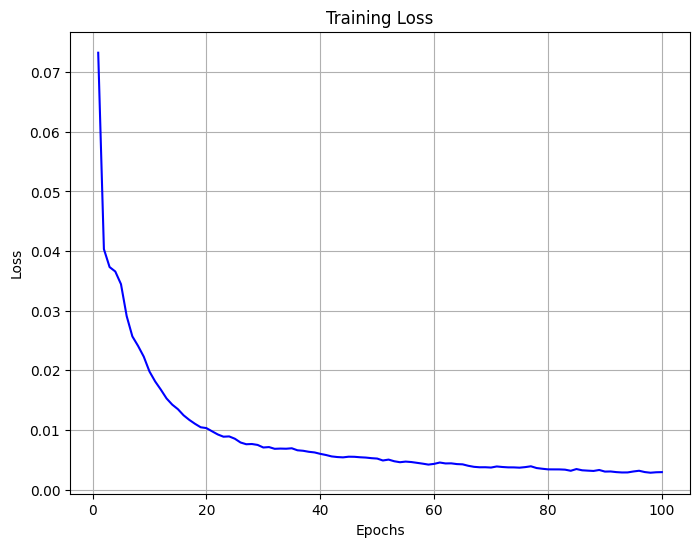

time: 321 ms (started: 2023-11-03 04:08:43 +00:00)


In [ ]:
# @title View Training Loss

training_loss = history.history['loss']

# Create a plot for the training loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(training_loss) + 1), training_loss, linestyle='-', color='b')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# @title Load My Model from Google Drive
auto_encoder = tf.keras.models.load_model("/content/drive/MyDrive/projectcode/weights/final_autoencoder2.h5", custom_objects={ 'loss': custom_loss(normalized_data, normalized_data) })
auto_encoder.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 125, 125, 17)]    0         
                                                                 
 conv2d_54 (Conv2D)          (None, 125, 125, 64)      9856      
                                                                 
 batch_normalization_81 (Ba  (None, 125, 125, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 125, 125, 64)      0         
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 63, 63, 32)        1846

17/17 [==============================] - 9s 67ms/step
414, 15


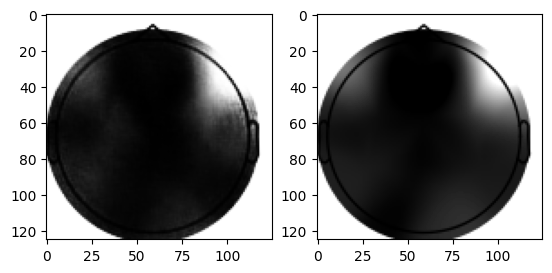

time: 12 s (started: 2023-12-02 23:27:34 +00:00)


In [ ]:
 # @title View the Original Image and the Autoencoder's Generated Image
import random
with tf.device('/device:GPU:0'):
  out = auto_encoder.predict(normalized_data)

num1 = random.randint(0, 534)
num2 = random.randint(0, 16)
print(f"{num1}, {num2}")
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(out[num1,:,:,num2], "gray") #reconstructed image
ax2.imshow(normalized_data[num1,:,:,num2], "gray") #original image
# plt.imshow(out[0,:,:,10], "gray")

In [ ]:
# @title Get Latent Representation
from tensorflow.keras.models import Model

encoder_model = Model(inputs = auto_encoder.input, outputs=auto_encoder.layers[17].output)

encoded_data = encoder_model.predict(normalized_data)

print(encoded_data.shape)

17/17 [==============================] - 1s 30ms/step
(535, 10)
time: 2.85 s (started: 2023-11-27 02:13:15 +00:00)


In [ ]:
# @title KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, n_init=20, random_state=0)
cluster_assignments = kmeans.fit_predict(encoded_data)
print(cluster_assignments.shape)

print(np.count_nonzero(cluster_assignments == 0))
print(np.count_nonzero(cluster_assignments == 1))
print(np.count_nonzero(cluster_assignments == 2))

(535,)
104
218
213
time: 1.26 s (started: 2023-11-27 02:13:17 +00:00)


17


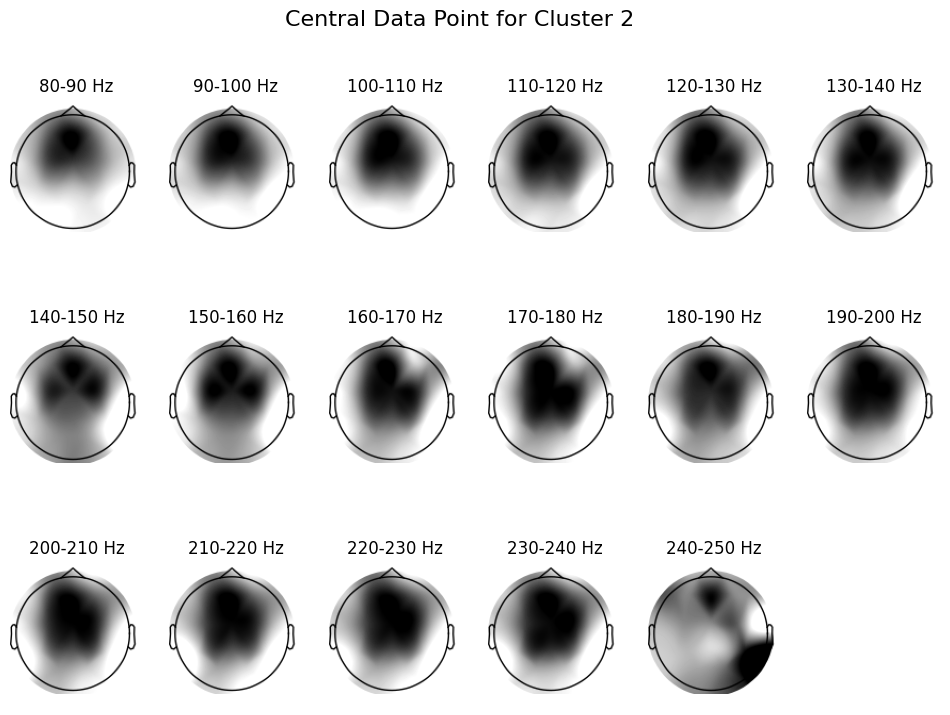

time: 1.76 s (started: 2023-11-27 02:13:19 +00:00)


In [ ]:
# @title Get the Visualizations for the Central Data Point
from scipy.spatial.distance import euclidean

closest_pt_idx = []
for iclust in range(kmeans.n_clusters):
    cluster_pts = encoded_data[kmeans.labels_ == iclust]
    cluster_pts_indices = np.where(kmeans.labels_ == iclust)[0]

    cluster_cen = kmeans.cluster_centers_[iclust]
    min_idx = np.argmin([euclidean(encoded_data[idx], cluster_cen) for idx in cluster_pts_indices])

    closest_pt_idx.append(cluster_pts_indices[min_idx])

num_cluster = 2

fig, axes = plt.subplots(3, 6, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)
i = 0
fig.suptitle(f"Central Data Point for Cluster {num_cluster}", fontsize=16)

frequency_ranges = [f"{i}-{i+10} Hz" for i in range(80, 250, 10)]
print(len(frequency_ranges))

for x in range(2):
    for y in range(6):
        axes[x, y].imshow(normalized_data[closest_pt_idx[num_cluster], :, :, i], cmap="gray")
        axes[x, y].axis('off')
        axes[x, y].set_title(f'{frequency_ranges[i]}')
        i += 1

for y in range(5):
    axes[2, y].imshow(normalized_data[closest_pt_idx[num_cluster], :, :, i], cmap="gray")
    axes[2, y].axis('off')
    axes[2, y].set_title(f'{frequency_ranges[i]}')

    i += 1

for y in range(5, 6):
    axes[2, y].axis('off')

plt.show()

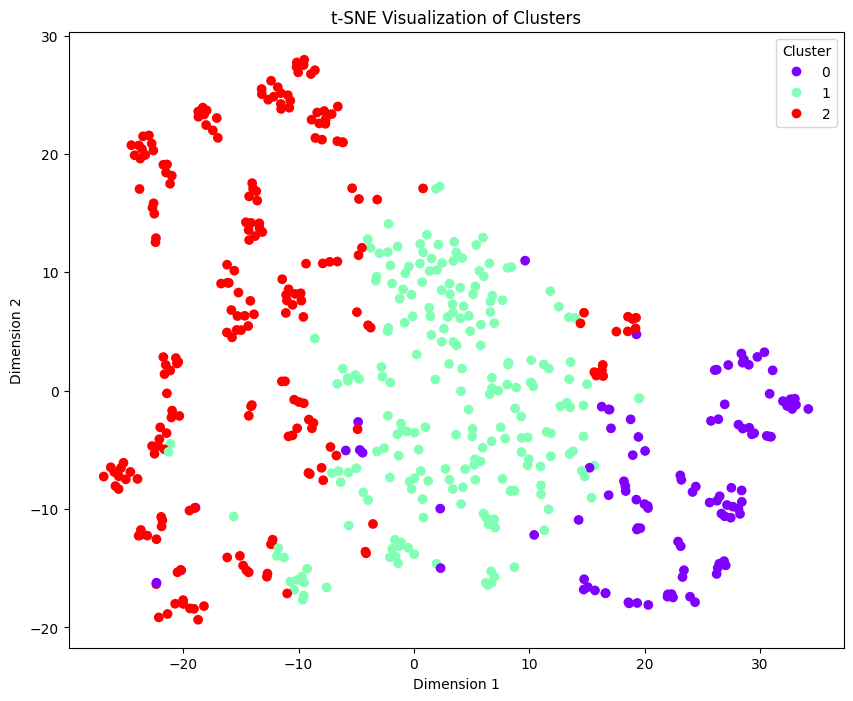

time: 3.6 s (started: 2023-11-27 02:13:21 +00:00)


In [ ]:
# @title Visualize Clusters with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


tsne = TSNE(n_components=2, random_state=0)
embedded_data = tsne.fit_transform(encoded_data)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=cluster_assignments, cmap='rainbow')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

legend = plt.legend(*scatter.legend_elements(), title='Cluster')

plt.show()

[-0.00096674  0.37833668]


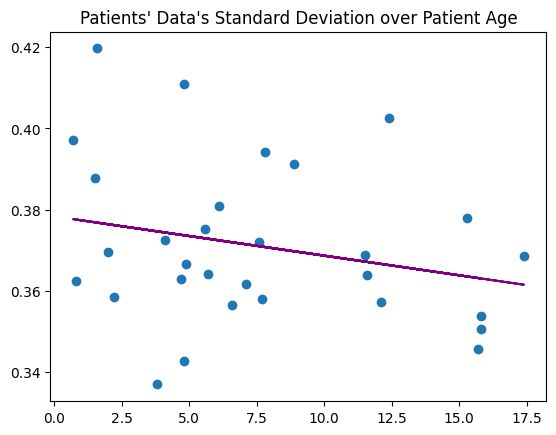

r=-0.24421442466496074, p=0.19340328934170128
time: 424 ms (started: 2023-11-27 02:13:24 +00:00)


In [ ]:
# @title Standard Deviation Over Age
ages = [5.6, 1.6, 4.8, 12.4, 6.6, 3.8, 4.9, 5.7, 2.2, 11.5, 4.7, 4.1, 0.7, 7.1, 12.1, 15.8, 11.6, 7.8, 1.5, 17.4, 0.8, 7.7, 15.3, 4.8, 6.1, 2.0, 8.9, 7.6, 15.8, 15.7]
mapping = []
all_means = []
for i in range(18):
  mapping.append((i * 18, i * 18 + 17))

mapping.append((324, 336))

for i in range(19, 30):
  mapping.append((337 + (i-19) * 18, (i-19) * 18 + 337 + 17))
stds = []

for map in mapping:
  std_dev_pixel_value = np.std(normalized_data[map[0]:map[1]])
  stds.append(std_dev_pixel_value)

coefs = np.polyfit(ages, stds, 1)
print(coefs)
line = np.poly1d(coefs)
plt.scatter(ages, stds)
plt.plot(ages, line(ages), color='purple')
plt.title("Patients' Data's Standard Deviation over Patient Age")
plt.show()

import scipy.stats as stats
r, p = stats.pearsonr(ages, stds)

print(f"r={r}, p={p}")

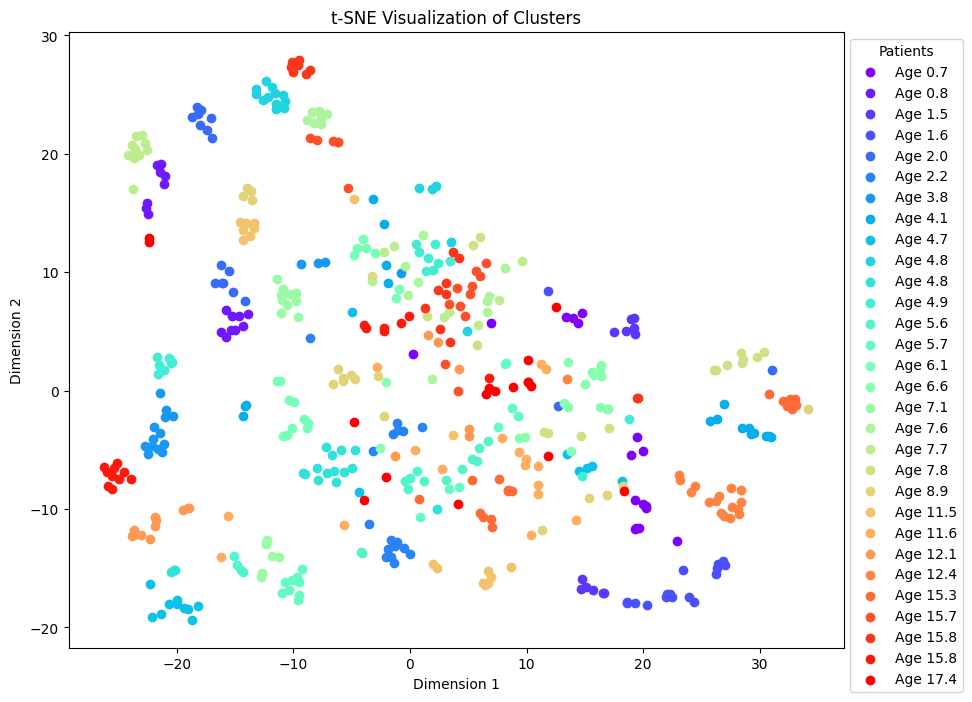

time: 882 ms (started: 2023-11-27 02:13:25 +00:00)


In [ ]:
# @title Visualize All Patients' Clusters
combined = list(zip(ages, mapping))
sorted_combined = sorted(combined, key=lambda x:x[0])

plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, len(sorted_combined)))  # generates colors for each patient
legend_elements = []
for i, (age, map_range) in enumerate(sorted_combined):
    plt.scatter(embedded_data[map_range[0]:map_range[1], 0], embedded_data[map_range[0]:map_range[1], 1], c=[colors[i]], label=f'Age {age}')
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=f'Age {age}'))


# legend
legend = plt.legend(title="Patients", loc='upper left', bbox_to_anchor=(1, 1))

plt.title('t-SNE Visualization of Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()


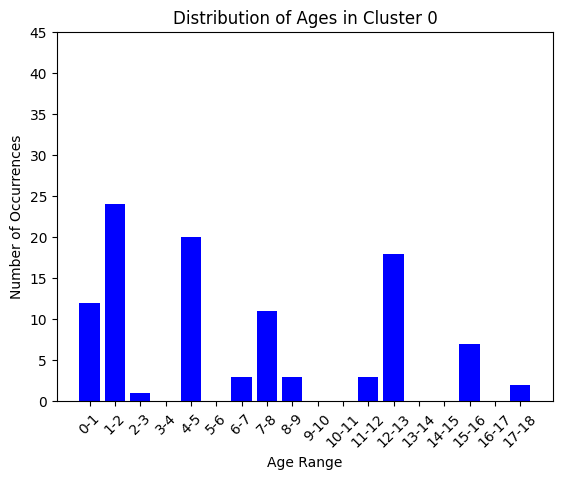

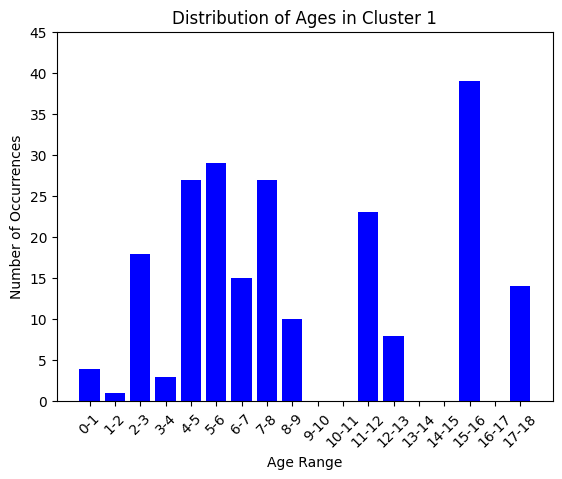

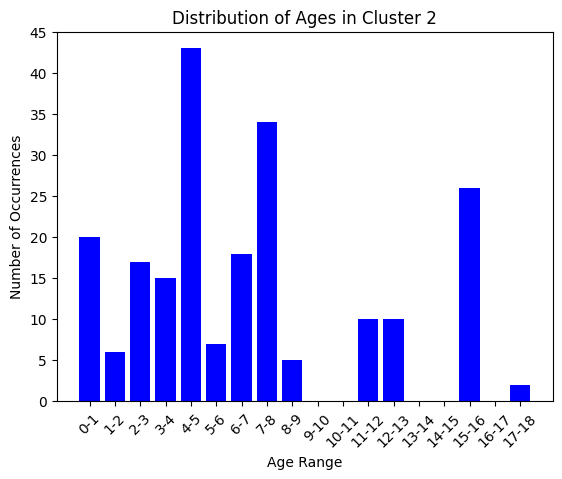

time: 1.2 s (started: 2023-11-24 03:23:56 +00:00)


In [ ]:
# @title Bar Charts
from collections import Counter
num_clusters = 3

for_stacked = []

for cluster_num in range(num_clusters):
  index_sorted_by_age = []
  for age, (start_range, end_range) in sorted_combined:
      for num in range(start_range, end_range + 1):
          index_sorted_by_age.append((num, age))
  indexes_in_cluster = []
  for i, a in index_sorted_by_age:
    if cluster_assignments[i] == cluster_num:
      indexes_in_cluster.append((a, i))

  age_counts = Counter(age for age, _ in indexes_in_cluster)
  result = [(age, count) for age, count in age_counts.items()]
  # ranges of ages
  def age_to_range(age):
      lower_bound = int(age)
      upper_bound = lower_bound + 1
      return f"{lower_bound}-{upper_bound}"

  age_ranges = {}
  age_ranges_list = [f"{i}-{i+1}" for i in range(18)]

  # count num of ages in range
  for age, count in result:
      age_range = age_to_range(age)
      age_ranges[age_range] = age_ranges.get(age_range, 0) + count

  for r in age_ranges_list:
    if r not in age_ranges:
      age_ranges[r] = 0

  # convert dictionary into tuples
  result = list(age_ranges.items())
  result.sort(key=lambda x: int(x[0].split('-')[0]))
  for_stacked.append(result)
  # creating bar chart
  age_ranges, counts = zip(*result)
  plt.bar(age_ranges, counts, color='blue')
  plt.xlabel('Age Range')
  plt.ylabel('Number of Occurrences')
  plt.ylim([0, 45])
  plt.title(f'Distribution of Ages in Cluster {cluster_num}')
  plt.xticks(rotation=45)
  # Show the plot
  plt.show()

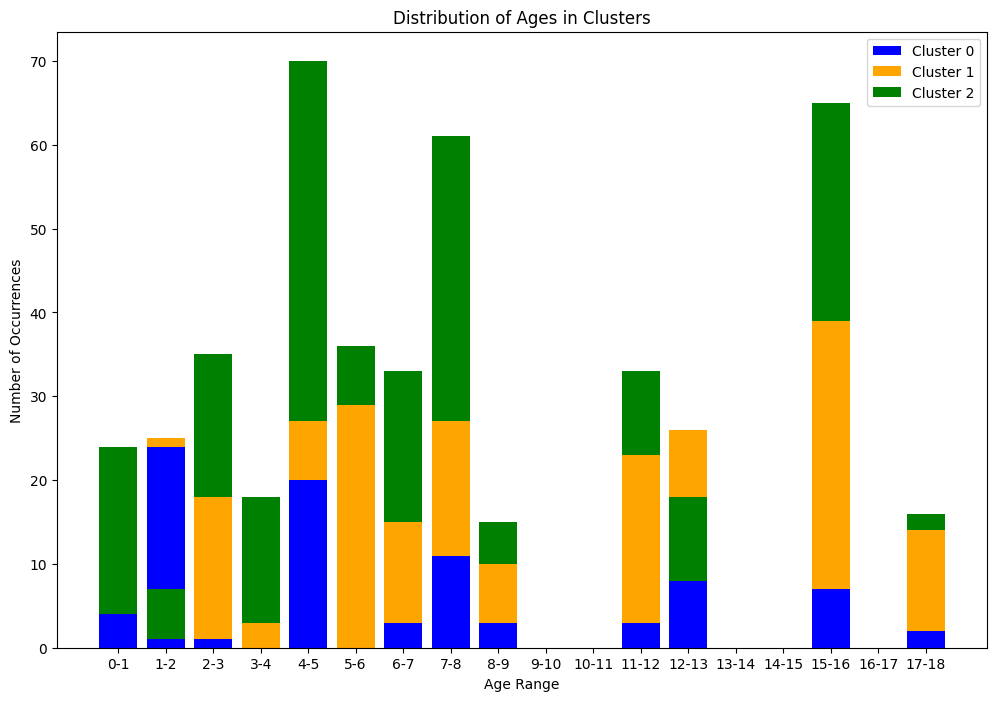

time: 587 ms (started: 2023-11-24 03:23:59 +00:00)


In [ ]:
# @title Distribution of Ages in Clusters

age_ranges, counts0 = zip(*for_stacked[0])
age_ranges, counts1 = zip(*for_stacked[1])
age_ranges, counts2 = zip(*for_stacked[2])

counts0 = np.array(counts0)
counts1 = np.array(counts1)
counts2 = np.array(counts2)

fig, ax = plt.subplots(figsize=(12, 8))

bar_positions = np.arange(len(age_ranges))

ax.bar(bar_positions, counts0, label='Cluster 0', color='blue')

ax.bar(bar_positions, counts1, label='Cluster 1', color='orange', bottom=counts0)

ax.bar(bar_positions, counts2, label='Cluster 2', color='green', bottom=counts1)

# Customize the plot
ax.set_xlabel('Age Range')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Distribution of Ages in Clusters')
ax.set_xticks(bar_positions)
ax.set_xticklabels(age_ranges)
ax.legend()

plt.show()

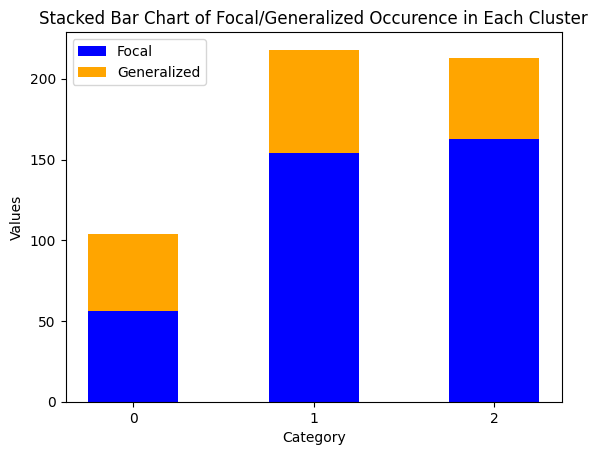

time: 182 ms (started: 2023-11-27 02:47:04 +00:00)


In [ ]:
# @title View the Amount of Focal vs. Generalized Epilepsy in Each Cluster
f = "focal"
g = "generalized"
f_or_g = [f, g, f, g, f, f, f, g, f, f, f, f, g, g, f, g, g, f, f, f, g, f, f, f, f, f, f, f, f, g]

fg_and_ranges = list(zip(f_or_g, mapping))

clusters_and_f_count = {0:0, 1:0, 2:0}
clusters_and_g_count = {0:0, 1:0, 2:0}
akdfj = []
c_assignments = list(cluster_assignments)
for i, map in enumerate(mapping):
  for index in range(map[0], map[1] + 1):
    if c_assignments[index] == 0:
      if f_or_g[i] == f:
        clusters_and_f_count[0] = clusters_and_f_count[0] + 1
      else:
        clusters_and_g_count[0] = clusters_and_g_count[0] + 1
    elif c_assignments[index] == 1:
      if f_or_g[i] == f:
        clusters_and_f_count[1] = clusters_and_f_count[1] + 1
      else:
        clusters_and_g_count[1] = clusters_and_g_count[1] + 1
    elif c_assignments[index] == 2:
      if f_or_g[i] == f:
        clusters_and_f_count[2] = clusters_and_f_count[2] + 1
      else:
        clusters_and_g_count[2] = clusters_and_g_count[2] + 1

categories = list(clusters_and_f_count.keys())
values1 = list(clusters_and_f_count.values())
values2 = list(clusters_and_g_count.values())

values1 = np.array(values1)
values2 = np.array(values2)

fig, ax = plt.subplots()
bar_width = 0.5
bar_positions = np.arange(len(categories))

ax.bar(bar_positions, values1, bar_width, label='Focal', color='blue')

ax.bar(bar_positions, values2, bar_width, label='Generalized', color='orange', bottom=values1)

ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('Stacked Bar Chart of Focal/Generalized Occurence in Each Cluster')
ax.set_xticks(bar_positions)
ax.set_xticklabels(categories)
ax.legend()
plt.show()